In [1]:
# PDF Content Extraction Tool for Google Colab
# AI/Python Intern Assignment - Part 1

# Step 1: Install required packages
print("Installing required packages...")
!pip install PyMuPDF pillow pdfplumber -q

# Step 2: Import libraries
import fitz  # PyMuPDF
import json
import os
from PIL import Image
import io
import re
from typing import List, Dict, Any
from google.colab import files
import zipfile
import shutil

class ColabPDFExtractor:
    def __init__(self, pdf_path: str, output_dir: str = "extracted_content"):
        self.pdf_path = pdf_path
        self.output_dir = output_dir
        self.images_dir = os.path.join(output_dir, "images")

        # Create output directories
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.images_dir, exist_ok=True)

    def extract_text_from_pdf(self) -> List[Dict[str, Any]]:
        print("Extracting text content...")
        doc = fitz.open(self.pdf_path)
        pages_content = []

        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text = page.get_text()

            pages_content.append({
                "page_number": page_num + 1,
                "text": text.strip(),
                "images": []
            })
            print(f"   Page {page_num + 1} processed")

        doc.close()
        return pages_content

    def extract_images_from_pdf(self, pages_content: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        print("Extracting images...")
        doc = fitz.open(self.pdf_path)
        total_images = 0

        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            image_list = page.get_images(full=True)

            for img_index, img in enumerate(image_list):
                try:
                    xref = img[0]
                    pix = fitz.Pixmap(doc, xref)

                    if pix.n - pix.alpha < 4:
                        img_filename = f"page{page_num + 1}_image{img_index + 1}.png"
                        img_path = os.path.join(self.images_dir, img_filename)

                        pix.save(img_path)

                        pages_content[page_num]["images"].append(img_path)
                        total_images += 1
                        print(f"   Saved: {img_filename}")

                    pix = None
                except Exception as e:
                    print(f"   Error extracting image {img_index + 1} from page {page_num + 1}: {str(e)}")

        doc.close()
        print(f"Total images extracted: {total_images}")
        return pages_content

    def parse_questions_and_options(self, pages_content: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        print("Parsing questions and options...")
        questions_data = []

        for page in pages_content:
            text = page["text"]
            images = page["images"]
            page_num = page["page_number"]

            lines = [line.strip() for line in text.split('\n') if line.strip()]

            question_patterns = [
                r'^(\d+\.?\s*)?(.+\?)\s*$',
                r'^(\d+\.?\s*)?(What|Which|How|Where|When|Why|Find|Choose|Select|Identify).+',
                r'.*next figure.*',
                r'.*complete.*pattern.*',
                r'.*missing.*number.*',
                r'.*count.*',
                r'.*many.*'
            ]

            current_question = None
            current_options = []
            current_question_number = None

            for line in lines:
                is_question = any(re.search(pattern, line, re.IGNORECASE) for pattern in question_patterns)

                number_match = re.match(r'^(\d+)\.?\s*(.+)', line)
                if number_match and (is_question or len(line) > 10):
                    is_question = True
                    current_question_number = number_match.group(1)

                if is_question:
                    if current_question:
                        questions_data.append({
                            "question_number": current_question_number,
                            "question": current_question,
                            "page": page_num,
                            "images": images[0] if images else "",
                            "option_images": images[1:] if len(images) > 1 else [],
                            "options_text": current_options,
                            "all_page_images": images
                        })

                    current_question = line
                    current_options = []

                elif re.match(r'^[A-Z]\)', line) or re.match(r'^\([A-Z]\)', line):
                    current_options.append(line)

            if current_question:
                questions_data.append({
                    "question_number": current_question_number,
                    "question": current_question,
                    "page": page_num,
                    "images": images[0] if images else "",
                    "option_images": images[1:] if len(images) > 1 else [],
                    "options_text": current_options,
                    "all_page_images": images
                })

        print(f"Total questions identified: {len(questions_data)}")
        return questions_data

    def extract_content(self) -> Dict[str, Any]:
        print(f"Starting extraction from: {self.pdf_path}")
        print("="*50)

        pages_content = self.extract_text_from_pdf()
        pages_content = self.extract_images_from_pdf(pages_content)
        questions_data = self.parse_questions_and_options(pages_content)

        output_data = {
            "source_file": self.pdf_path,
            "total_pages": len(pages_content),
            "total_questions": len(questions_data),
            "extraction_summary": {
                "pages_processed": len(pages_content),
                "total_images": sum(len(page['images']) for page in pages_content),
                "questions_found": len(questions_data)
            },
            "pages_content": pages_content,
            "questions": questions_data
        }

        json_output_path = os.path.join(self.output_dir, "extracted_content.json")
        with open(json_output_path, 'w', encoding='utf-8') as f:
            json.dump(output_data, f, indent=2, ensure_ascii=False)

        print("="*50)
        print("EXTRACTION COMPLETE!")
        print(f"Output saved to: {json_output_path}")
        print(f"Total pages processed: {len(pages_content)}")
        print(f"Total images extracted: {sum(len(page['images']) for page in pages_content)}")
        print(f"Total questions identified: {len(questions_data)}")

        return output_data

def upload_and_process_pdf():
    print("Please upload your PDF file...")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return None

    pdf_filename = list(uploaded.keys())[0]
    print(f"File uploaded: {pdf_filename}")

    extractor = ColabPDFExtractor(pdf_filename)

    try:
        extracted_data = extractor.extract_content()

        print("\n" + "="*60)
        print("DETAILED EXTRACTION SUMMARY")
        print("="*60)
        print(f"Source file: {extracted_data['source_file']}")
        print(f"Pages processed: {extracted_data['total_pages']}")
        print(f"Questions found: {extracted_data['total_questions']}")
        print(f"Images extracted: {extracted_data['extraction_summary']['total_images']}")

        if extracted_data['questions']:
            print(f"\nSAMPLE QUESTIONS (showing first 5):")
            print("-" * 40)
            for i, q in enumerate(extracted_data['questions'][:5], 1):
                print(f"\n{i}. {q['question']}")
                if q['question_number']:
                    print(f"   Question #{q['question_number']}")
                print(f"   Page: {q['page']}")
                if q['images']:
                    print(f"   Main image: {os.path.basename(q['images'])}")
                if q['option_images']:
                    print(f"   Option images: {len(q['option_images'])} found")
                if q['options_text']:
                    print(f"   Text options: {', '.join(q['options_text'][:2])}...")

        create_download_package()

        return extracted_data

    except Exception as e:
        print(f"Error during extraction: {str(e)}")
        print("Make sure you uploaded a valid PDF file!")
        return None

def create_download_package():
    print("\nCreating download package...")

    zip_filename = "extracted_content_package.zip"

    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        if os.path.exists("extracted_content/extracted_content.json"):
            zipf.write("extracted_content/extracted_content.json", "extracted_content.json")

        if os.path.exists("extracted_content/images"):
            for filename in os.listdir("extracted_content/images"):
                file_path = os.path.join("extracted_content/images", filename)
                zipf.write(file_path, f"images/{filename}")

    print(f"Package created: {zip_filename}")
    print("Downloading package...")
    files.download(zip_filename)

def display_extracted_images():
    images_dir = "extracted_content/images"
    if os.path.exists(images_dir):
        image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')][:6]

        if image_files:
            print(f"\nSAMPLE EXTRACTED IMAGES (showing first {len(image_files)}):")
            print("-" * 50)

            from IPython.display import Image as IPImage, display
            import matplotlib.pyplot as plt

            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()

            for i, img_file in enumerate(image_files):
                img_path = os.path.join(images_dir, img_file)
                try:
                    img = Image.open(img_path)
                    axes[i].imshow(img)
                    axes[i].set_title(img_file, fontsize=10)
                    axes[i].axis('off')
                except Exception as e:
                    axes[i].text(0.5, 0.5, f"Error loading\n{img_file}",
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].axis('off')

            for j in range(len(image_files), len(axes)):
                axes[j].axis('off')

            plt.tight_layout()
            plt.show()

def run_pdf_extraction():
    print("PDF Content Extraction Tool for Google Colab")
    print("=" * 60)
    print("This tool will:")
    print("1. Upload your PDF file")
    print("2. Extract all text content")
    print("3. Extract all images")
    print("4. Identify questions and options")
    print("5. Create structured JSON output")
    print("6. Package everything for download")
    print("=" * 60)

    result = upload_and_process_pdf()

    if result:
        print("\nWould you like to preview some extracted images?")
        display_extracted_images()

        print("\n" + "="*60)
        print("SUCCESS! Your PDF has been fully processed!")
        print("Check your downloads for the complete package")
        print("="*60)

        return result
    else:
        print("\nExtraction failed. Please try again with a valid PDF file.")
        return None

# Run the extraction tool
print("Ready to extract content from your PDF!")
print("Run the cell below to start:")
print()
print("extracted_data = run_pdf_extraction()")


Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 73.8 MB/s eta 0:00:00
Ready to extract content from your PDF!
Run the cell below to start:

extracted_data = run_pdf_extraction()


PDF Content Extraction Tool for Google Colab
This tool will:
1. Upload your PDF file
2. Extract all text content
3. Extract all images
4. Identify questions and options
5. Create structured JSON output
6. Package everything for download
Please upload your PDF file...


Saving IMO class 1 Maths Olympiad Sample Paper 1 for the year 2024-25.pdf to IMO class 1 Maths Olympiad Sample Paper 1 for the year 2024-25.pdf
File uploaded: IMO class 1 Maths Olympiad Sample Paper 1 for the year 2024-25.pdf
Starting extraction from: IMO class 1 Maths Olympiad Sample Paper 1 for the year 2024-25.pdf
Extracting text content...
   Page 1 processed
   Page 2 processed
   Page 3 processed
   Page 4 processed
   Page 5 processed
   Page 6 processed
   Page 7 processed
   Page 8 processed
   Page 9 processed
   Page 10 processed
   Page 11 processed
   Page 12 processed
   Page 13 processed
   Page 14 processed
Extracting images...
   Saved: page1_image1.png
   Saved: page1_image2.png
   Saved: page1_image3.png
   Saved: page1_image4.png
   Saved: page1_image5.png
   Saved: page1_image6.png
   Saved: page1_image7.png
   Saved: page1_image8.png
   Saved: page1_image9.png
   Saved: page1_image10.png
   Saved: page2_image1.png
   Saved: page2_image2.png
   Saved: page2_image3.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Would you like to preview some extracted images?

SAMPLE EXTRACTED IMAGES (showing first 6):
--------------------------------------------------


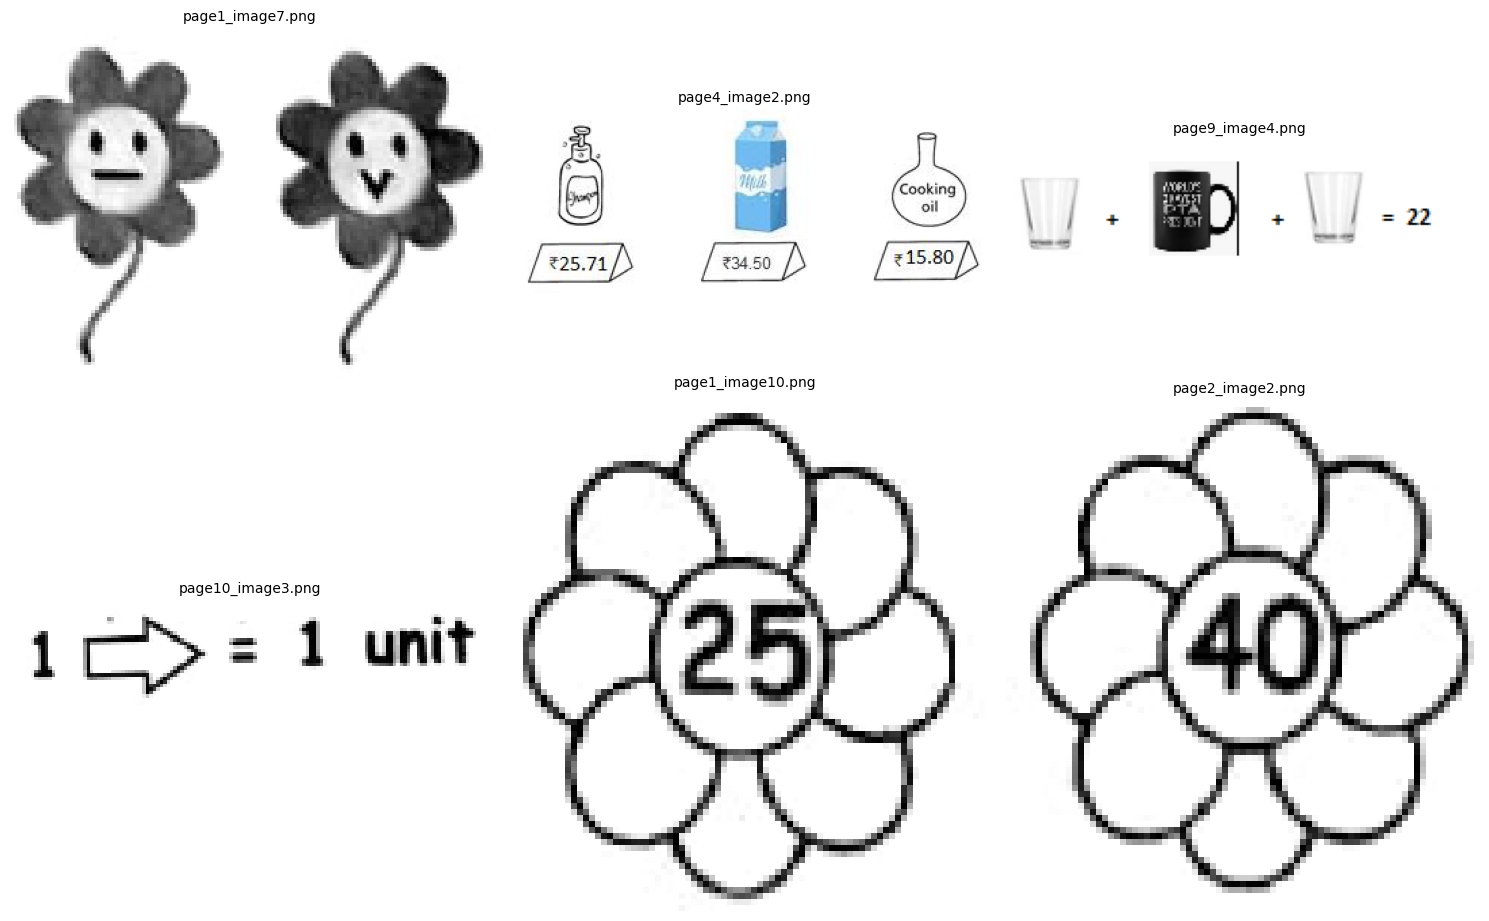


SUCCESS! Your PDF has been fully processed!
Check your downloads for the complete package


In [2]:
extracted_data = run_pdf_extraction()